In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import medmnist
from medmnist import BloodMNIST
from medmnist import INFO
import numpy as np
from PIL import Image
import random

In [3]:
class BloodCellClassifier(nn.Module):
    def __init__(self):
        super(BloodCellClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def train_validate(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=10):
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    val_accs = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(num_epochs):
        
        model.train()
        running_train_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.append(predicted)
                all_labels.append(labels)

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        all_predictions = torch.cat(all_predictions).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        val_precision = precision_score(all_labels, all_predictions, average='macro')
        val_recall = recall_score(all_labels, all_predictions, average='macro')
        val_f1 = f1_score(all_labels, all_predictions, average='macro')

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Val Precision: {val_precision:.4f} | "
              f"Val Recall: {val_recall:.4f} | "
              f"Val F1: {val_f1:.4f}")

   
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "val_precisions": val_precisions,
        "val_recalls": val_recalls,
        "val_f1s": val_f1s,
    }

In [5]:
def plot_val_metrics(metrics):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    epochs = range(1, len(metrics['train_losses']) + 1)

    ax1.plot(epochs, metrics['val_losses'], color='red')
    ax1.set_title('Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(epochs, metrics['val_accs'], color='blue')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [6]:
num_epochs=20
used_classes = [0, 1, 3, 4, 5, 6]

In [7]:
label_map = {old: new for new, old in enumerate(sorted(used_classes))}

def remap_label(label):
    if isinstance(label, torch.Tensor):
        return label_map[label.item()]
    return label_map[label]

class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label_map):
        self.dataset = dataset
        self.label_map = label_map

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y = self.label_map[int(y)]
        return x, y


In [8]:
class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label_map):
        self.dataset = dataset
        self.label_map = dict(label_map)
        self.valid_remapped = set(range(len(label_map)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y = int(y.item() if torch.is_tensor(y) else y)

        if y in self.label_map:
            y = self.label_map[y]
        elif y in self.valid_remapped:
            pass                                  
        else:
            raise KeyError(
                f"Label {y} not in label_map and not already remapped "
                f"(expected one of {sorted(self.label_map.keys())} or 0..{len(self.valid_remapped)-1})."
            )
        return x, torch.tensor(y, dtype=torch.long)


In [9]:
def target_to_long(y):
    if isinstance(y, np.ndarray):
        y = int(y[0])
    else:
        y = int(y)
    return torch.tensor(y, dtype=torch.long)

In [27]:
class BlurredDataset(Dataset):
    def __init__(self, dataset, blur=None):
        self.dataset = dataset
        self.blur = blur or transforms.GaussianBlur(kernel_size=3, sigma=(1.0, 3.0))
        if hasattr(dataset, "labels"):
            self.labels = dataset.labels 

    def __len__(self): return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.blur: 
            image = self.blur(image)
        if torch.is_tensor(label):
            label = label.long()
        else:
            label = torch.tensor(int(label), dtype=torch.long)
        return image, label

blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(1.0, 3.0))

## original bloodMNIST dataset

In [10]:
info = INFO['bloodmnist']
task = info['task']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

trainset_original = DataClass(split='train', transform=transforms.ToTensor(), target_transform=target_to_long, download=True)
valset_original   = DataClass(split='val', transform=transforms.ToTensor(), target_transform=target_to_long, download=True)
testset_original  = DataClass(split='test', transform=transforms.ToTensor(), target_transform=target_to_long, download=True)

train_used_idx = [
    i for i, (_, lbl) in enumerate(trainset_original)
    if lbl.item() in used_classes
]

val_used_idx = [
    i for i, (_, lbl) in enumerate(valset_original)
    if lbl.item() in used_classes
]

test_used_idx = [
    i for i, (_, lbl) in enumerate(testset_original)
    if lbl.item() in used_classes
]

trainset_filtered = Subset(trainset_original, train_used_idx)
valset_filtered   = Subset(valset_original, val_used_idx)
testset_filtered  = Subset(testset_original, test_used_idx)


trainset = RemappedDataset(trainset_filtered, label_map)
valset   = RemappedDataset(valset_filtered,   label_map)
testset  = RemappedDataset(testset_filtered,  label_map)

train_dataloader = DataLoader(trainset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=128, shuffle=False)

In [11]:
label_counts = {}
for _, targets in train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 852 images
Label 1: 2181 images
Label 2: 2026 images
Label 3: 849 images
Label 4: 993 images
Label 5: 2330 images


Epoch 1/20 | Train Loss: 1.3785 | Val Loss: 0.9522 | Val Acc: 62.25% | Val Precision: 0.5618 | Val Recall: 0.5792 | Val F1: 0.5334
Epoch 2/20 | Train Loss: 0.8403 | Val Loss: 0.7737 | Val Acc: 67.55% | Val Precision: 0.6768 | Val Recall: 0.6719 | Val F1: 0.6447
Epoch 3/20 | Train Loss: 0.6855 | Val Loss: 0.5818 | Val Acc: 78.74% | Val Precision: 0.7478 | Val Recall: 0.7439 | Val F1: 0.7450
Epoch 4/20 | Train Loss: 0.5718 | Val Loss: 0.5128 | Val Acc: 79.27% | Val Precision: 0.7913 | Val Recall: 0.7212 | Val F1: 0.7397
Epoch 5/20 | Train Loss: 0.5059 | Val Loss: 0.5810 | Val Acc: 76.48% | Val Precision: 0.8094 | Val Recall: 0.6940 | Val F1: 0.7103
Epoch 6/20 | Train Loss: 0.4665 | Val Loss: 0.5002 | Val Acc: 81.69% | Val Precision: 0.7892 | Val Recall: 0.8286 | Val F1: 0.7799
Epoch 7/20 | Train Loss: 0.4275 | Val Loss: 0.3728 | Val Acc: 85.33% | Val Precision: 0.8599 | Val Recall: 0.8023 | Val F1: 0.8218
Epoch 8/20 | Train Loss: 0.3812 | Val Loss: 0.5311 | Val Acc: 80.26% | Val Precisio

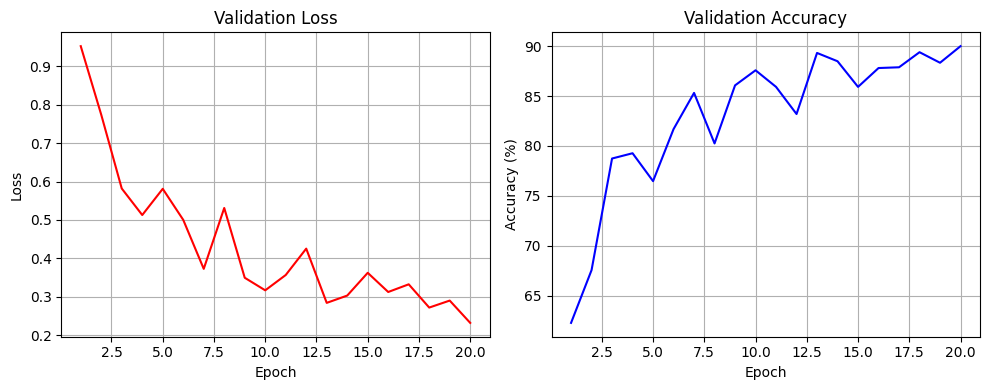

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(original_model.parameters(), lr=0.0015)

original_metrics = train_validate(
    model=original_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(original_metrics)

## generated images based on bloodMNIST

In [16]:
class GeneratedBloodMNIST(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.images = np.load(data_path)  
        self.labels = np.load(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        if image.ndim == 2: 
            image = Image.fromarray(image).convert("RGB")
        else:
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

In [17]:
generated_dataset = GeneratedBloodMNIST(
    data_path='./generated_blood_cell_images1/generated_train_data.npy',
    label_path='./generated_blood_cell_images1/generated_train_labels.npy',
    transform=transforms.ToTensor()
)

total_size = len(generated_dataset)
generated_train_size = int(0.7 * total_size)
generated_val_size = int(0.1 * total_size)
generated_test_size = total_size - generated_train_size - generated_val_size

generated_trainset, generated_valset, generated_testset = random_split(
    generated_dataset,
    [generated_train_size, generated_val_size, generated_test_size],
    generator=torch.Generator().manual_seed(42)
)

generated_train_used_idx = [
    i for i, (_, lbl) in enumerate(generated_trainset)
    if lbl.item() in used_classes
]

generated_val_used_idx = [
    i for i, (_, lbl) in enumerate(generated_valset)
    if lbl.item() in used_classes
]

generated_test_used_idx = [
    i for i, (_, lbl) in enumerate(generated_testset)
    if lbl.item() in used_classes
]

generated_trainset_filtered = Subset(generated_trainset, generated_train_used_idx)
generated_valset_filtered   = Subset(generated_valset, generated_val_used_idx)
generated_testset_filtered  = Subset(generated_testset, generated_test_used_idx)

generated_trainset = RemappedDataset(generated_trainset_filtered, label_map)
generated_valset   = RemappedDataset(generated_valset_filtered,   label_map)
generated_testset  = RemappedDataset(generated_testset_filtered,  label_map)

generated_train_dataloader = DataLoader(generated_trainset, batch_size=128, shuffle=True)
generated_val_dataloader   = DataLoader(generated_valset, batch_size=128, shuffle=False)
generated_test_dataloader   = DataLoader(generated_testset, batch_size=128, shuffle=False)

In [18]:
label_counts = {}
for _, targets in generated_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 708 images
Label 1: 687 images
Label 2: 701 images
Label 3: 696 images
Label 4: 691 images
Label 5: 728 images


Epoch 1/20 | Train Loss: 1.7315 | Val Loss: 1.3846 | Val Acc: 63.60% | Val Precision: 0.7775 | Val Recall: 0.6580 | Val F1: 0.5930
Epoch 2/20 | Train Loss: 0.9630 | Val Loss: 0.8123 | Val Acc: 68.63% | Val Precision: 0.7898 | Val Recall: 0.7138 | Val F1: 0.6914
Epoch 3/20 | Train Loss: 0.5957 | Val Loss: 0.5627 | Val Acc: 78.34% | Val Precision: 0.8661 | Val Recall: 0.7834 | Val F1: 0.7588
Epoch 4/20 | Train Loss: 0.4965 | Val Loss: 0.4355 | Val Acc: 84.40% | Val Precision: 0.8776 | Val Recall: 0.8449 | Val F1: 0.8414
Epoch 5/20 | Train Loss: 0.4294 | Val Loss: 0.4498 | Val Acc: 81.63% | Val Precision: 0.8671 | Val Recall: 0.8281 | Val F1: 0.8081
Epoch 6/20 | Train Loss: 0.3583 | Val Loss: 0.3471 | Val Acc: 89.08% | Val Precision: 0.8969 | Val Recall: 0.8942 | Val F1: 0.8914
Epoch 7/20 | Train Loss: 0.3062 | Val Loss: 0.3002 | Val Acc: 89.60% | Val Precision: 0.9061 | Val Recall: 0.8997 | Val F1: 0.8979
Epoch 8/20 | Train Loss: 0.2997 | Val Loss: 0.3569 | Val Acc: 86.83% | Val Precisio

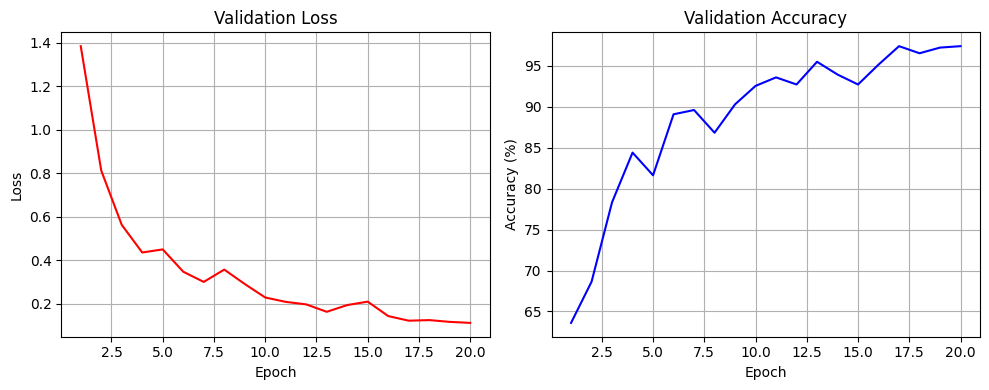

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generated_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(generated_model.parameters(), lr=0.0015)

generated_metrics = train_validate(
    model=generated_model,
    train_dataloader=generated_train_dataloader,
    val_dataloader=generated_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(generated_metrics)

## combined dataset

In [24]:
combined_trainset = ConcatDataset([trainset, generated_trainset])
combined_valset   = ConcatDataset([valset, generated_valset])
combined_testset  = ConcatDataset([testset, generated_testset])

combined_train_dataloader = DataLoader(combined_trainset, batch_size=128, shuffle=True)
combined_val_dataloader   = DataLoader(combined_valset, batch_size=128, shuffle=False)
combined_test_dataloader  = DataLoader(combined_testset, batch_size=128, shuffle=False)


In [25]:
label_counts = {}
for _, targets in combined_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 1560 images
Label 1: 2868 images
Label 2: 2727 images
Label 3: 1545 images
Label 4: 1684 images
Label 5: 3058 images


Epoch 1/20 | Train Loss: 1.4018 | Val Loss: 1.0404 | Val Acc: 63.56% | Val Precision: 0.6516 | Val Recall: 0.5754 | Val F1: 0.5611
Epoch 2/20 | Train Loss: 0.8317 | Val Loss: 0.6457 | Val Acc: 78.04% | Val Precision: 0.7612 | Val Recall: 0.7627 | Val F1: 0.7534
Epoch 3/20 | Train Loss: 0.6043 | Val Loss: 0.5607 | Val Acc: 78.30% | Val Precision: 0.7901 | Val Recall: 0.7527 | Val F1: 0.7452
Epoch 4/20 | Train Loss: 0.5001 | Val Loss: 0.4369 | Val Acc: 84.83% | Val Precision: 0.8256 | Val Recall: 0.8400 | Val F1: 0.8281
Epoch 5/20 | Train Loss: 0.4217 | Val Loss: 0.4017 | Val Acc: 85.52% | Val Precision: 0.8589 | Val Recall: 0.8357 | Val F1: 0.8386
Epoch 6/20 | Train Loss: 0.3717 | Val Loss: 0.3702 | Val Acc: 86.57% | Val Precision: 0.8526 | Val Recall: 0.8620 | Val F1: 0.8480
Epoch 7/20 | Train Loss: 0.3336 | Val Loss: 0.4170 | Val Acc: 84.41% | Val Precision: 0.8571 | Val Recall: 0.8477 | Val F1: 0.8291
Epoch 8/20 | Train Loss: 0.3258 | Val Loss: 0.3316 | Val Acc: 87.84% | Val Precisio

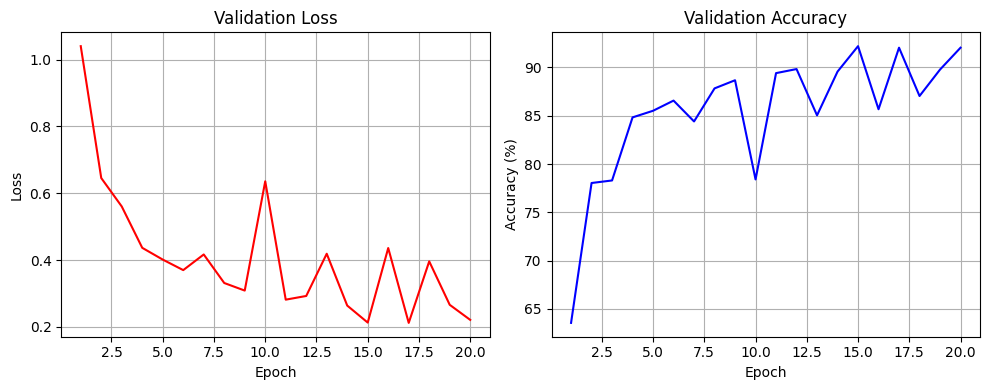

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.0015)

combined_metrics = train_validate(
    model=combined_model,
    train_dataloader=combined_train_dataloader,
    val_dataloader=combined_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(combined_metrics)

## combined blurred dataset

In [28]:
blurred_trainset = BlurredDataset(trainset, blur=transforms.GaussianBlur(kernel_size=3, sigma=(1.0, 3.0)))
blurred_valset   = BlurredDataset(valset, blur=transforms.GaussianBlur(kernel_size=3, sigma=2.0))
blurred_testset  = BlurredDataset(testset, blur=transforms.GaussianBlur(kernel_size=3, sigma=2.0))

blurred_train_dataloader  = DataLoader(blurred_valset, batch_size=128, shuffle=True)
blurred_val_dataloader  = DataLoader(blurred_trainset, batch_size=128, shuffle=False)
blurred_test_dataloader  = DataLoader(blurred_testset, batch_size=128, shuffle=False)

In [31]:
combined_blurred_trainset = ConcatDataset([blurred_trainset, generated_trainset])
combined_blurred_valset   = ConcatDataset([blurred_valset, generated_valset])
combined_blurred_testset  = ConcatDataset([blurred_testset, generated_testset])

combined_blurred_train_dataloader = DataLoader(combined_blurred_trainset, batch_size=128, shuffle=True)
combined_blurred_val_dataloader   = DataLoader(combined_blurred_valset, batch_size=128, shuffle=False)
combined_blurred_test_dataloader  = DataLoader(combined_blurred_testset, batch_size=128, shuffle=False)


Epoch 1/20 | Train Loss: 1.3414 | Val Loss: 0.9817 | Val Acc: 59.56% | Val Precision: 0.6748 | Val Recall: 0.5691 | Val F1: 0.5364
Epoch 2/20 | Train Loss: 0.7260 | Val Loss: 0.5958 | Val Acc: 75.83% | Val Precision: 0.7583 | Val Recall: 0.7234 | Val F1: 0.7190
Epoch 3/20 | Train Loss: 0.5437 | Val Loss: 0.5553 | Val Acc: 76.46% | Val Precision: 0.8090 | Val Recall: 0.7219 | Val F1: 0.7204
Epoch 4/20 | Train Loss: 0.4714 | Val Loss: 0.7936 | Val Acc: 70.14% | Val Precision: 0.7611 | Val Recall: 0.6672 | Val F1: 0.6194
Epoch 5/20 | Train Loss: 0.4574 | Val Loss: 0.7852 | Val Acc: 72.14% | Val Precision: 0.8688 | Val Recall: 0.6351 | Val F1: 0.6345
Epoch 6/20 | Train Loss: 0.3954 | Val Loss: 0.6718 | Val Acc: 73.93% | Val Precision: 0.8423 | Val Recall: 0.7325 | Val F1: 0.7166
Epoch 7/20 | Train Loss: 0.3619 | Val Loss: 0.4553 | Val Acc: 81.73% | Val Precision: 0.8285 | Val Recall: 0.8071 | Val F1: 0.7841
Epoch 8/20 | Train Loss: 0.3213 | Val Loss: 0.2933 | Val Acc: 88.94% | Val Precisio

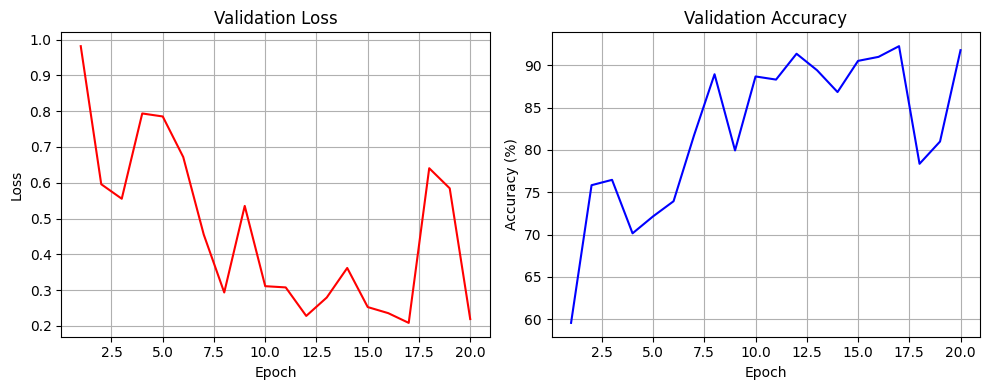

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_blurred_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_blurred_model.parameters(), lr=0.0015)

combined_blurred_metrics = train_validate(
    model=combined_blurred_model,
    train_dataloader=combined_blurred_train_dataloader,
    val_dataloader=combined_blurred_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(combined_blurred_metrics)

## balanced dataset

In [34]:
def balance_dataset(original_dataset, generated_dataset, target_per_class, classes):

    def indices_by_label(dataset, label):
        return [i for i, (_, lbl) in enumerate(dataset) if int(lbl) == label]

    balanced_indices = []
    combined_dataset = ConcatDataset([original_dataset, generated_dataset])
    offset = len(original_dataset)

    for label in classes:
        original_indices = indices_by_label(original_dataset, label)
        generated_indices = indices_by_label(generated_dataset, label)

        random.shuffle(original_indices)
        random.shuffle(generated_indices)

        total_available = len(original_indices) + len(generated_indices)

        if total_available <= target_per_class:
            chosen_orig = original_indices
            chosen_gen_shifted = [i + offset for i in generated_indices]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)
        else:
            needed_from_gen = target_per_class - len(original_indices)
            needed_from_gen = max(0, needed_from_gen)
            chosen_orig = original_indices[:target_per_class]
            chosen_gen_shifted = [i + offset for i in generated_indices[:needed_from_gen]]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)

    return Subset(combined_dataset, balanced_indices)

In [35]:
def labels_array(ds):
    ys = np.empty(len(ds), dtype=np.int64)
    for i in range(len(ds)):
        _, y = ds[i]
        if isinstance(y, torch.Tensor):
            y = y.item()
        ys[i] = int(y)
    return ys

def balance_dataset(original_dataset, generated_dataset, target_per_class, classes=None, seed=42):
    rng = random.Random(seed)
    np_rng = np.random.default_rng(seed)

    lbl_original = labels_array(original_dataset)
    lbl_generated  = labels_array(generated_dataset)

    if classes is None:
        classes = sorted(set(lbl_original.tolist()) | set(lbl_generated.tolist()))
    else:
        classes = sorted(int(c) for c in classes)

    original_by_class = {c: np.flatnonzero(lbl_original == c).tolist() for c in classes}
    generated_by_class  = {c: np.flatnonzero(lbl_generated  == c).tolist()  for c in classes}

    for c in classes:
        rng.shuffle(original_by_class[c])
        rng.shuffle(generated_by_class[c])

    take_original, take_generated = [], []

    for c in classes:
        original_i = original_by_class[c]
        generated_i  = generated_by_class[c]

        n_from_original = min(len(original_i), target_per_class)
        take_original.extend(original_i[:n_from_original])

        needed_generated = target_per_class - n_from_original
        if needed_generated > 0 and len(generated_i) > 0:
            n_from_generated = min(needed_generated, len(generated_i))
            take_generated.extend(generated_i[:n_from_generated])

    combined = ConcatDataset([
        Subset(original_dataset,  take_original),
        Subset(generated_dataset, take_generated),
    ])
    perm = np_rng.permutation(len(take_original) + len(take_generated)).tolist()
    return Subset(combined, perm)

In [36]:
target_per_class = 2500
n = len(used_classes)

concat_original_dataset = ConcatDataset([trainset, valset, testset]) 
concat_generated_dataset = ConcatDataset([generated_testset, generated_valset, generated_testset])

balanced_dataset = balance_dataset(
    original_dataset=concat_original_dataset,
    generated_dataset=concat_generated_dataset,
    target_per_class=target_per_class,
    #classes=range(n),
    seed=42
)

balanced_size = len(balanced_dataset)
balanced_train_size = int(0.7 * balanced_size)
balanced_val_size   = int(0.1 * balanced_size)
balanced_test_size  = balanced_size - balanced_train_size - balanced_val_size

balanced_trainset, balanced_valset, balanced_testset = torch.utils.data.random_split(
    balanced_dataset,
    [balanced_train_size, balanced_val_size, balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)
balanced_train_dataloader = DataLoader(balanced_trainset, batch_size=128, shuffle=True)
balanced_val_dataloader   = DataLoader(balanced_valset,   batch_size=128, shuffle=False)
balanced_test_dataloader  = DataLoader(balanced_testset,  batch_size=128, shuffle=False)

In [37]:
label_counts = {}
for _, targets in balanced_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 1213 images
Label 1: 1718 images
Label 2: 1778 images
Label 3: 1199 images
Label 4: 1348 images
Label 5: 1739 images


Epoch 1/20 | Train Loss: 1.3546 | Val Loss: 0.8698 | Val Acc: 69.96% | Val Precision: 0.7089 | Val Recall: 0.6799 | Val F1: 0.6738
Epoch 2/20 | Train Loss: 0.8037 | Val Loss: 0.6642 | Val Acc: 76.42% | Val Precision: 0.7523 | Val Recall: 0.7563 | Val F1: 0.7489
Epoch 3/20 | Train Loss: 0.6403 | Val Loss: 0.5824 | Val Acc: 80.08% | Val Precision: 0.7925 | Val Recall: 0.7948 | Val F1: 0.7882
Epoch 4/20 | Train Loss: 0.5383 | Val Loss: 0.4761 | Val Acc: 83.66% | Val Precision: 0.8282 | Val Recall: 0.8243 | Val F1: 0.8231
Epoch 5/20 | Train Loss: 0.4798 | Val Loss: 0.4035 | Val Acc: 85.29% | Val Precision: 0.8402 | Val Recall: 0.8447 | Val F1: 0.8415
Epoch 6/20 | Train Loss: 0.4253 | Val Loss: 0.4383 | Val Acc: 83.81% | Val Precision: 0.8406 | Val Recall: 0.8382 | Val F1: 0.8261
Epoch 7/20 | Train Loss: 0.3769 | Val Loss: 0.4333 | Val Acc: 85.29% | Val Precision: 0.8566 | Val Recall: 0.8480 | Val F1: 0.8468
Epoch 8/20 | Train Loss: 0.3818 | Val Loss: 0.3595 | Val Acc: 86.61% | Val Precisio

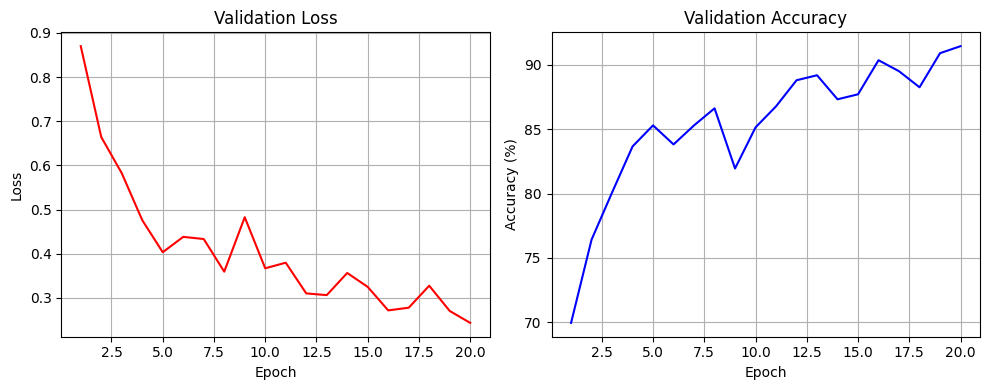

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
balanced_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(balanced_model.parameters(), lr=0.0015)

balanced_metrics = train_validate(
    model=balanced_model,
    train_dataloader=balanced_train_dataloader,
    val_dataloader=balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(balanced_metrics)

## balanced blurred dataset

In [39]:
target_per_class = 2500
n = len(used_classes)

concat_blurred_dataset = ConcatDataset([blurred_trainset, blurred_valset, blurred_testset]) 
concat_generated_dataset = ConcatDataset([generated_testset, generated_valset, generated_testset])

blurred_balanced_dataset = balance_dataset(
    original_dataset=concat_blurred_dataset,
    generated_dataset=concat_generated_dataset,
    target_per_class=target_per_class,
    #classes=range(n),
    seed=42
)

blurred_balanced_size = len(blurred_balanced_dataset)
blurred_balanced_train_size = int(0.7 * blurred_balanced_size)
blurred_balanced_val_size   = int(0.1 * blurred_balanced_size)
blurred_balanced_test_size  = blurred_balanced_size - blurred_balanced_train_size - blurred_balanced_val_size

blurred_balanced_trainset, blurred_balanced_valset, blurred_balanced_testset = torch.utils.data.random_split(
    blurred_balanced_dataset,
    [blurred_balanced_train_size, blurred_balanced_val_size, blurred_balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

blurred_balanced_train_dataloader = DataLoader(blurred_balanced_trainset, batch_size=128, shuffle=True)
blurred_balanced_val_dataloader   = DataLoader(blurred_balanced_valset,   batch_size=128, shuffle=False)
blurred_balanced_test_dataloader  = DataLoader(blurred_balanced_testset,  batch_size=128, shuffle=False)

In [40]:
label_counts = {}
for _, targets in blurred_balanced_train_dataloader:
    binc = torch.bincount(targets, minlength=len(used_classes))
    for lbl, cnt in enumerate(binc.tolist()):
        if cnt > 0:
            label_counts[lbl] = label_counts.get(lbl, 0) + cnt

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")


Label 0: 1213 images
Label 1: 1718 images
Label 2: 1778 images
Label 3: 1199 images
Label 4: 1348 images
Label 5: 1739 images


Epoch 1/20 | Train Loss: 1.5597 | Val Loss: 1.2684 | Val Acc: 47.08% | Val Precision: 0.6128 | Val Recall: 0.5029 | Val F1: 0.4167
Epoch 2/20 | Train Loss: 1.0502 | Val Loss: 0.9137 | Val Acc: 66.85% | Val Precision: 0.6791 | Val Recall: 0.6367 | Val F1: 0.6257
Epoch 3/20 | Train Loss: 0.8872 | Val Loss: 0.8318 | Val Acc: 65.99% | Val Precision: 0.7105 | Val Recall: 0.6212 | Val F1: 0.6030
Epoch 4/20 | Train Loss: 0.7586 | Val Loss: 0.7102 | Val Acc: 73.46% | Val Precision: 0.7503 | Val Recall: 0.7048 | Val F1: 0.7002
Epoch 5/20 | Train Loss: 0.6659 | Val Loss: 0.6260 | Val Acc: 76.81% | Val Precision: 0.7892 | Val Recall: 0.7426 | Val F1: 0.7485
Epoch 6/20 | Train Loss: 0.5821 | Val Loss: 0.5336 | Val Acc: 80.31% | Val Precision: 0.8002 | Val Recall: 0.8003 | Val F1: 0.7810
Epoch 7/20 | Train Loss: 0.5261 | Val Loss: 0.4696 | Val Acc: 83.11% | Val Precision: 0.8180 | Val Recall: 0.8189 | Val F1: 0.8153
Epoch 8/20 | Train Loss: 0.4955 | Val Loss: 0.5521 | Val Acc: 80.70% | Val Precisio

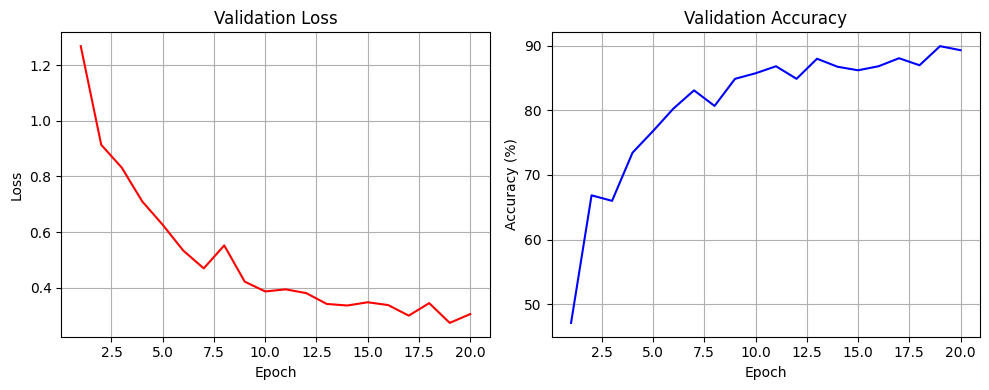

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blurred_balanced_model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(blurred_balanced_model.parameters(), lr=0.0015)

blurred_balanced_metrics = train_validate(
    model=blurred_balanced_model,
    train_dataloader=blurred_balanced_train_dataloader,
    val_dataloader=blurred_balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(blurred_balanced_metrics)

In [42]:
def test_model(model, test_dataloader, device, classes=range(n)):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_predictions.append(preds)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    cm=confusion_matrix(all_labels, all_predictions, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    

    print(f"Test Accuracy: {accuracy:.4f} | "
            f"Test Precision: {precision:.4f} | "
            f"Test Recall: {recall:.4f} | "
            f"Test F1: {f1:.4f}")

    disp.plot()
    plt.show()

Original model
Test Accuracy: 0.9049 | Test Precision: 0.9030 | Test Recall: 0.8850 | Test F1: 0.8926


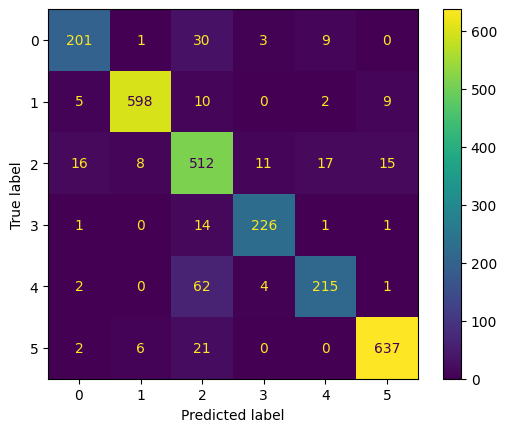

Generated model
Test Accuracy: 0.4273 | Test Precision: 0.4236 | Test Recall: 0.4652 | Test F1: 0.3868


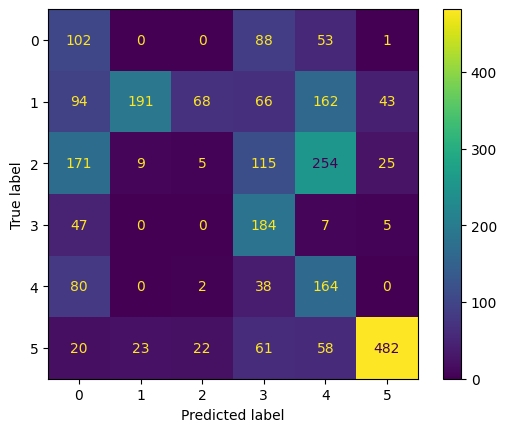

Combined model
Test Accuracy: 0.8773 | Test Precision: 0.8619 | Test Recall: 0.8739 | Test F1: 0.8621


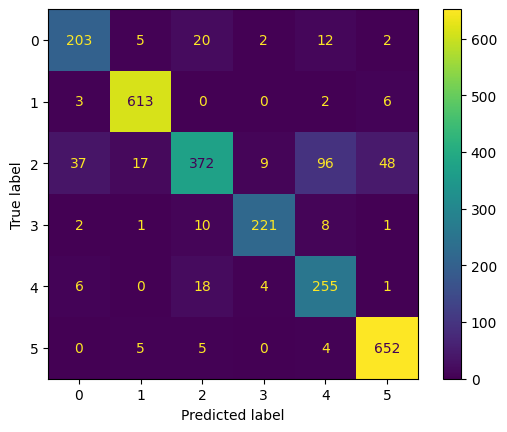

Combined blurred model
Test Accuracy: 0.8458 | Test Precision: 0.8365 | Test Recall: 0.8335 | Test F1: 0.8175


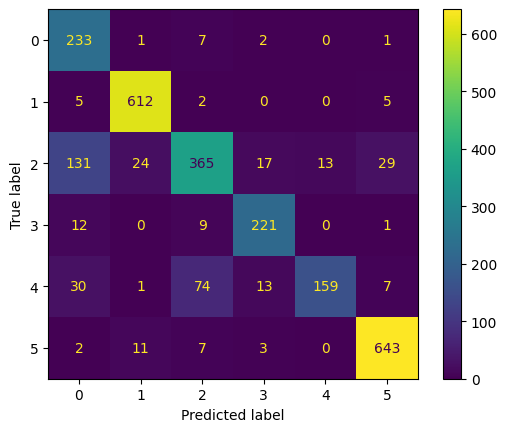

Balanced model
Test Accuracy: 0.9360 | Test Precision: 0.9292 | Test Recall: 0.9254 | Test F1: 0.9270


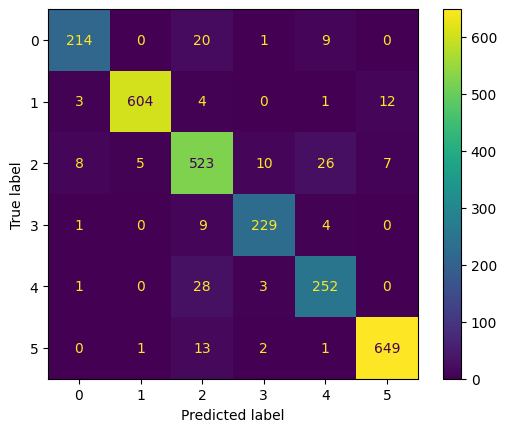

Blurred balanced model
Test Accuracy: 0.8754 | Test Precision: 0.8454 | Test Recall: 0.8583 | Test F1: 0.8474


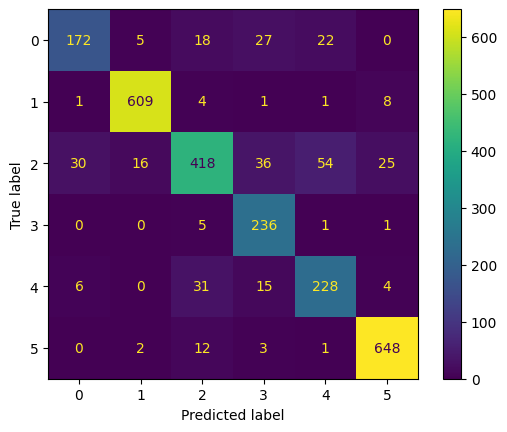

In [43]:
print("Original model")
test_model(model=original_model, test_dataloader=test_dataloader, device=device)

print("Generated model")
test_model(model=generated_model, test_dataloader=test_dataloader, device=device)

print("Combined model")
test_model(model=combined_model, test_dataloader=test_dataloader, device=device)

print("Combined blurred model")
test_model(model=combined_blurred_model, test_dataloader=test_dataloader, device=device)

print("Balanced model")
test_model(model=balanced_model, test_dataloader=test_dataloader, device=device)

print("Blurred balanced model")
test_model(model=blurred_balanced_model, test_dataloader=test_dataloader, device=device)

Original model
Test Accuracy: 0.7716 | Test Precision: 0.8690 | Test Recall: 0.6893 | Test F1: 0.7058


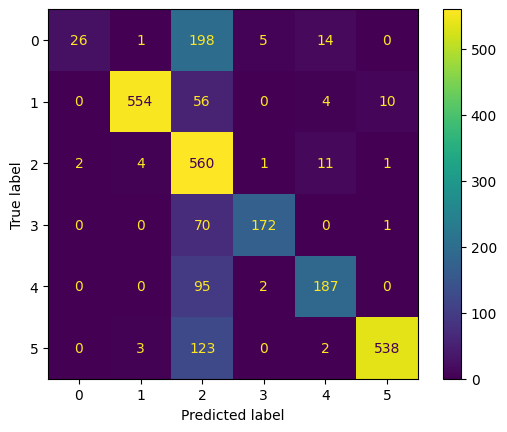

Generated model
Test Accuracy: 0.4383 | Test Precision: 0.4309 | Test Recall: 0.4739 | Test F1: 0.4176


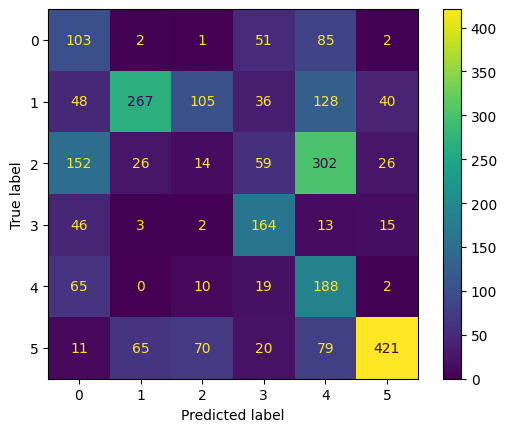

Combined model
Test Accuracy: 0.8523 | Test Precision: 0.8516 | Test Recall: 0.8194 | Test F1: 0.8195


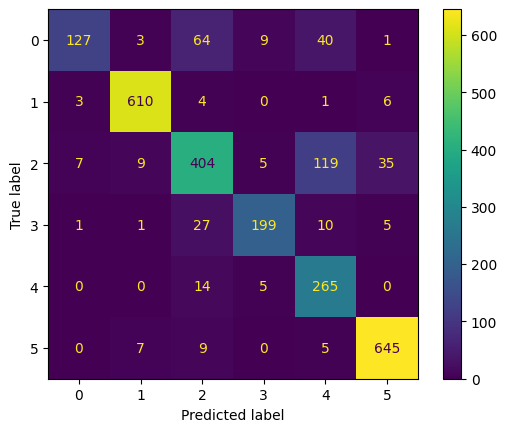

Combined blurred model
Test Accuracy: 0.8837 | Test Precision: 0.8872 | Test Recall: 0.8497 | Test F1: 0.8621


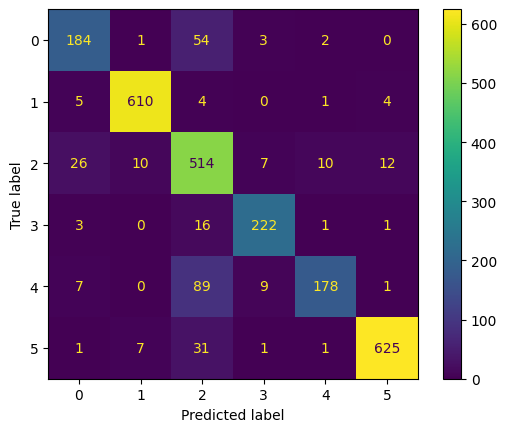

Balanced model
Test Accuracy: 0.8364 | Test Precision: 0.8587 | Test Recall: 0.8055 | Test F1: 0.8031


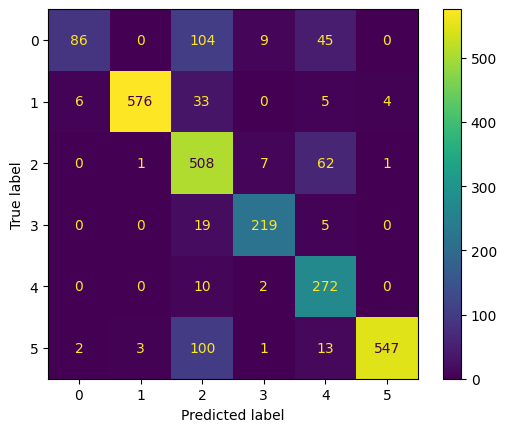

Blurred balanced model
Test Accuracy: 0.9049 | Test Precision: 0.9107 | Test Recall: 0.8761 | Test F1: 0.8886


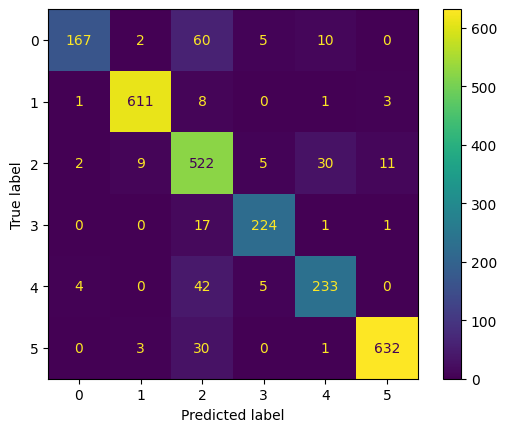

In [44]:
print("Original model")
test_model(model=original_model, test_dataloader=blurred_test_dataloader, device=device)

print("Generated model")
test_model(model=generated_model, test_dataloader=blurred_test_dataloader, device=device)

print("Combined model")
test_model(model=combined_model, test_dataloader=blurred_test_dataloader, device=device)

print("Combined blurred model")
test_model(model=combined_blurred_model, test_dataloader=blurred_test_dataloader, device=device)

print("Balanced model")
test_model(model=balanced_model, test_dataloader=blurred_test_dataloader, device=device)

print("Blurred balanced model")
test_model(model=blurred_balanced_model, test_dataloader=blurred_test_dataloader, device=device)